### Spatial Interpolation Competition!

In this assignment, you will be using the ordinary kriging method to interpolate the annual mean temperature data for two states: Arizona and Illinois.
***
Description of the data

The temperature data were retrived from https://prism.oregonstate.edu/normals/. The original dataset covers the entire US with a ~4km by 4km grid. I clipped the data for Arizona and Illinois, and randomly sampled 200 pixels for each state, from this gridded climate product.
***

Competition!

Because I have the "true" temperature data, I am able to assess your kriging fittings by compare your interpolated temperature with the "true" temperature. 

The criterion I will be using is the root-mean squared error (RMSE): sqrt(mean(predict - true)**2)

*** 
Evaluation

This assignment worths 10%, the basic task is to use Kriging to interpolate the temperature for the two states. If you finish the basic task, you earn the full-credit. Additionally, we will have two winners (one for AZ, one for IL) who have the best interpolation accuracy. The winner will get 1% **extra** credit.

***
Several details:

- Please use the lab jupyter notebook as a template.
- Display the two interpolation maps (one for AZ and one for IL) in jupyter notebook as the final products, don't clear your outputs.
- There are many parameters in `OrdinaryKriging()` that you can play with to better fit the variogram. For example, you can change the values in `nlags`, or `variogram_model`. The goal is to make the curve fits the variogram as better as possible.
- Use the following code for generating the x and y of a 0.04 degree resolution grid (this is slighly differernt from the lab). 

    `grid_x = np.arange(xmin, xmax, 0.04)
   grid_y = np.arange(ymin, ymax, 0.04)`
   
- Export your interpolated data using
    `interpolated_krig.to_csv("il_your_name.csv"`and `interpolated_krig.to_csv("az_your_name.csv")`. And upload both to Learn when you submit your assignment. If you don't do this, you will give up your chance to win the extra credits.


In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np


In [2]:
#Read county shapefiles
az = gpd.read_file("tl_2015_04_cousub/tl_2015_04_cousub.shp")
il = gpd.read_file("IL_BNDY_County/IL_BNDY_County_Py.shp")

In [3]:
#Read temperature data
az_temp = gpd.read_file("AZ_prec_samples/AZ_temp_samples.shp")
il_temp = gpd.read_file("IL_prec_samples/IL_temp_samples.shp")

Arizon Temperature 

In [4]:
# az temperature
gdf = gpd.GeoDataFrame(az_temp, crs="EPSG:4269")

In [5]:
gdf = gdf.to_crs(az.crs)

<AxesSubplot:>

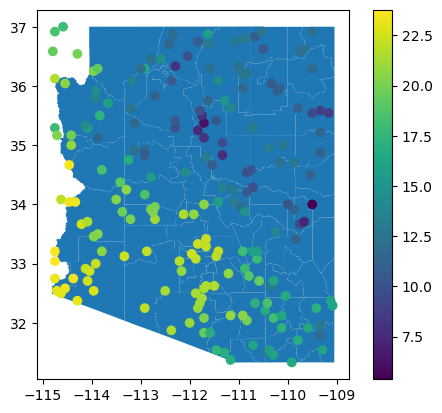

In [7]:
ax = az.plot()
gdf.plot(ax=ax, column="temp",legend=True)

In [8]:
xmin, ymin, xmax, ymax = az.total_bounds
print(xmin, ymin, xmax, ymax)

-114.816591 31.332176999999998 -109.045172 37.003724999999996


In [11]:
grid_x = np.arange(xmin, xmax, 0.04)
grid_y = np.arange(ymin, ymax, 0.04)

### Kriging

In [12]:
from pykrige.ok import OrdinaryKriging
help(OrdinaryKriging)

Help on class OrdinaryKriging in module pykrige.ok:

class OrdinaryKriging(builtins.object)
 |  OrdinaryKriging(x, y, z, variogram_model='linear', variogram_parameters=None, variogram_function=None, nlags=6, weight=False, anisotropy_scaling=1.0, anisotropy_angle=0.0, verbose=False, enable_plotting=False, enable_statistics=False, coordinates_type='euclidean', exact_values=True, pseudo_inv=False, pseudo_inv_type='pinv')
 |  
 |  Convenience class for easy access to 2D Ordinary Kriging.
 |  
 |  Parameters
 |  ----------
 |  x : array_like
 |      X-coordinates of data points.
 |  y : array_like
 |      Y-coordinates of data points.
 |  z : array-like
 |      Values at data points.
 |  variogram_model : str or GSTools CovModel, optional
 |      Specifies which variogram model to use; may be one of the following:
 |      linear, power, gaussian, spherical, exponential, hole-effect.
 |      Default is linear variogram model. To utilize a custom variogram model,
 |      specify 'custom'; you

Essentially, you need to pass:

- `x`: X-coordinates of monitor stations.
- `y`: Y-coordinates of monitor stations.
- `z`: Ozone values at monitor stations.
- `variogram_model`: Here you have the option to choose the variogram function. E.g. spherical, gaussian, linear, power, exponential, etc. In the code below, I used the spherical kernel.
- `variogram_parameters`: For more advanced modelling, you are able to set up the parameter for the variogram by explicitly define the sill, range and nugget. For example, you can follow this format to input your parameters for a gaussian function: `{'sill': s, 'range': r, 'nugget': n}`
- `nlags`: Number of averaging bins for the semivariogram. Default is 6.


Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 28.651721104537554
Full Sill: 28.651721104537557
Range: 4.3232821775713015
Nugget: 2.7869898526681776e-15 



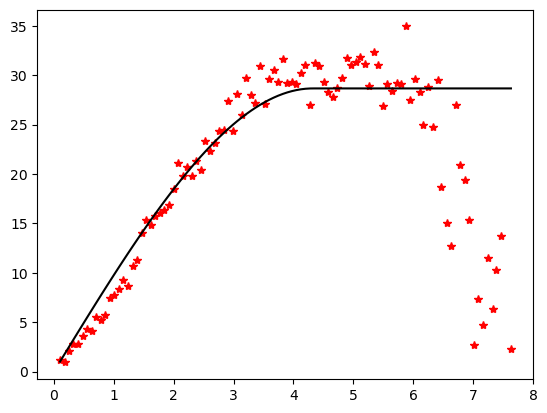

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



In [14]:
OK = OrdinaryKriging(x=gdf.geometry.x, 
                     y=gdf.geometry.y, 
                     z = gdf.temp, 
                     variogram_model='spherical',
                     verbose=True, enable_plotting=True,nlags=100,
                    )

z1, ss1 = OK.execute('grid', grid_x, grid_y)

In [15]:
#Here I'm using two standard deviation to show our uncertainty.

krig = np.hstack([z1.reshape(-1,1), 2*np.sqrt(ss1).reshape(-1,1)])

In [17]:
xintrp, yintrp = np.meshgrid(grid_x, grid_y)

interpolated_krig = gpd.GeoDataFrame(krig, crs=az.crs, geometry=
                    gpd.points_from_xy(x=xintrp.reshape(-1), y=yintrp.reshape(-1)))

In [18]:
interpolated_krig.columns = ["krig_pred","krig_std","geometry"]

interpolated_krig = gpd.clip(interpolated_krig, az)

Here are the codes for visualization.

Text(0.5, 1.0, 'temperature map of Arizona')

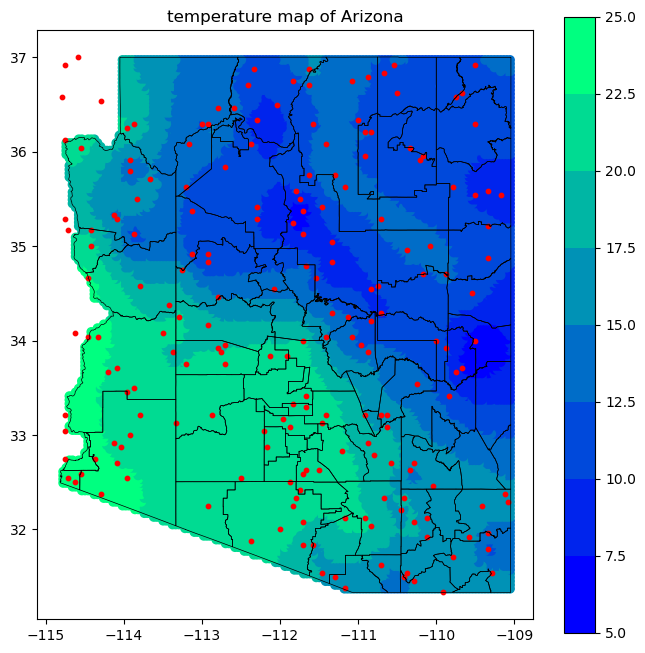

In [23]:
import matplotlib.pyplot as plt

#Using a winter colormap with 8 colors.
cmap = plt.get_cmap('winter',8)

#Specify the max and min of the colorbar to be 5 and 25.
ax = interpolated_krig.plot(column="krig_pred",figsize=(8, 8),
                            cmap=cmap,legend=True,vmin=5,vmax=25)

#Overlay the county boundaries
az.boundary.plot(ax=ax,color="black",linewidths=0.5)

#Overlay the stations
gdf.plot(ax=ax, color="red", markersize=10,)

plt.title("temperature map of Arizona")

Do the same thing for the uncertainty.

Text(0.5, 1.0, 'temperature map of Arizona uncertainty')

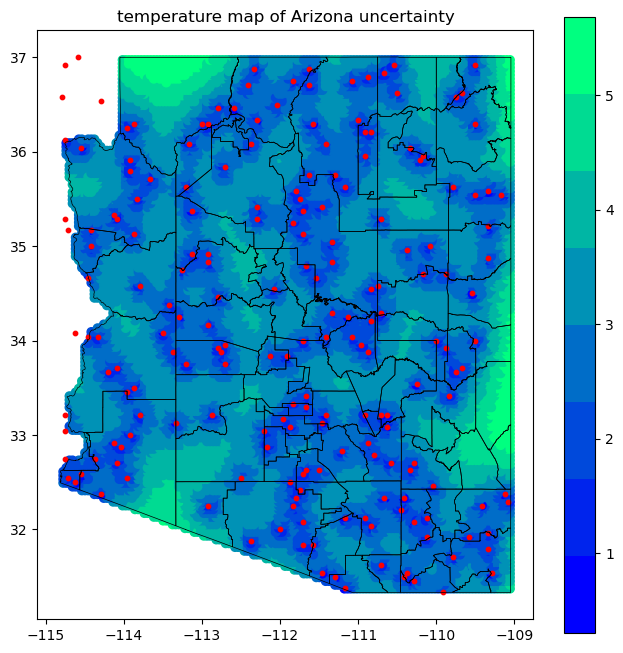

In [24]:
ax = interpolated_krig.plot(column="krig_std",figsize=(8, 8),cmap=cmap,legend=True)
az.boundary.plot(ax=ax,color="black",linewidths=0.5)
gdf.plot(ax=ax, color="red", markersize=10,)
plt.title("temperature map of Arizona uncertainty")

In [26]:
interpolated_krig.to_csv("az_zheng73.csv")